In [1]:
#Import Libraries

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose, Flatten, Dense, Dropout
from keras.constraints import max_norm
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import cv2
from keras.layers import Input
from keras.models import Model
from keras.models import load_model
from keras import optimizers
from keras.utils import to_categorical

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Load MNIST dataset

(input_train, target_train), (input_test, target_test) = mnist.load_data()


In [3]:
# Model configuration

total_images = input_train.shape[0]
img_width, img_height = input_train.shape[1], input_train.shape[2]

num_classes = 10
batch_size = 150
no_epochs = 10
validation_split = 0.2

noise_factor = 0.35


In [4]:
input_train = input_train.reshape(input_train.shape[0], img_width, img_height, 1)
input_test = input_test.reshape(input_test.shape[0], img_width, img_height, 1)
input_shape = (img_width, img_height, 1)


In [5]:
# Parse numbers as floats

input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

#convert numerical data out to categorical data out for classification
target_train_categorial = to_categorical(target_train,num_classes)
target_test_categorial = to_categorical(target_test, num_classes)


In [6]:
# Add noise

original_images = input_train
original_test_images = input_test

noise = np.random.normal(0, 1, original_images.shape)    #To create normal(Gaussian) distribution with mean = 0 and std_dev = 1
noise_test = np.random.normal(0, 1, original_test_images.shape)

noisy_input = original_images + noise_factor * noise
noisy_input_test = original_test_images + noise_factor * noise_test


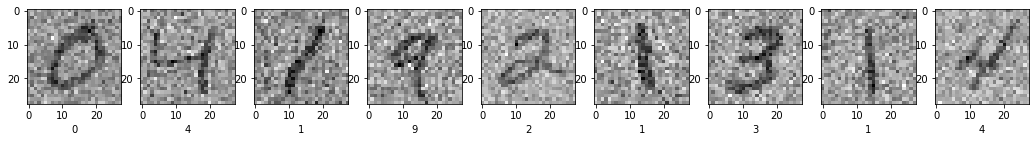

In [7]:
# To visualize noisy input data and its output label

j = 1
plt.figure(figsize=(20, 2))
for i in range(1,10):
    #print(target_train[j])
    ax = plt.subplot(1, 10, i)
    plt.imshow(noisy_input[i].reshape(28, 28), cmap="binary")  ### noisy_input
    plt.xlabel(target_train[j])
    j += 1

plt.show()

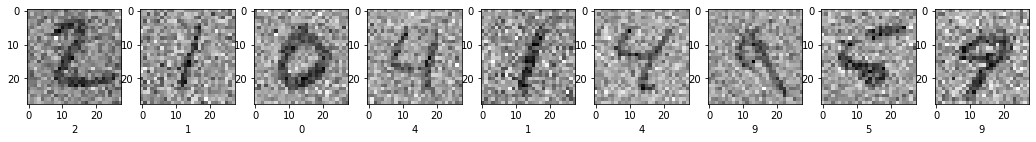

In [8]:
# To visualize noisy input test data and its output label

j = 1
plt.figure(figsize=(20, 2))
for i in range(1,10):
    #print(target_train[j])
    ax = plt.subplot(1, 10, i)
    plt.imshow(noisy_input_test[i].reshape(28, 28), cmap="binary") ### noisy input test data
    plt.xlabel(target_test[j])
    j += 1
    
plt.show()

In [9]:
# Create the Autoencoder model for Noisy to Denosiy conversion
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(Conv2DTranspose(32, kernel_size=(3,3), activation='relu'))
model.add(Conv2DTranspose(64, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same'))

model.summary()






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        18464     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 26, 26, 32)        9248      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 1)         577       
Total params: 47,425
Trainable params: 47,425
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Compile and fit data

model.compile(optimizer='adam', loss='binary_crossentropy')  ##loss = binary_crossentropy because we only have two classes in output noisy and original 




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
#train the model

model.fit(noisy_input, original_images,
                epochs=no_epochs,
                batch_size=batch_size,
                validation_split=validation_split)



Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 21s 430us/step - loss: 0.1181 - val_loss: 0.0835
Epoch 2/10
48000/48000 [==============================] - 17s 353us/step - loss: 0.0821 - val_loss: 0.0816
Epoch 3/10
48000/48000 [==============================] - 17s 355us/step - loss: 0.0806 - val_loss: 0.0809
Epoch 4/10
48000/48000 [==============================] - 17s 359us/step - loss: 0.0797 - val_loss: 0.0798
Epoch 5/10
48000/48000 [==============================] - 17s 353us/step - loss: 0.0792 - val_loss: 0.0793
Epoch 6/10
48000/48000 [==============================] - 18s 367us/step - loss: 0.0788 - val_loss: 0.0790
Epoch 7/10
48000/48000 [==============================] - 18s 366us/step - loss: 0.0785 - val_loss: 0.0787
Epoch 8/10
48000/48000 [==============================] - 17s 364us/step - loss: 0.0782 - val_loss: 0.0785
Epoch 9/10
48000/48000 [==============================] - 17s 364us/step - loss: 0.0780 - val

In [12]:
#Save the autoencoder model

model.save('autoenc.h5')


In [13]:
#Load the saved autoencoder model

model = load_model('autoenc.h5')


In [14]:

for layer in model.layers[:-1]:       # freeze layers of autoencoder to extract features (freezing all layers except last)
    layer.trainable = False

## create new model for classification (add dense layer)
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(10, activation="softmax")(x)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
model_final = Model(input = model.input, output = predictions) 
model_final.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        18464     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 26, 26, 32)        9248      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 1)         577       
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
__________

/home/automatonai-09/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [16]:
model_final.compile(optimizer='adam', loss = "categorical_crossentropy", metrics=["accuracy"])

model_final.fit(noisy_input, target_train_categorial,
                epochs=no_epochs,
                batch_size=batch_size,
                validation_split=validation_split)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 13s 279us/step - loss: 0.2838 - acc: 0.9128 - val_loss: 0.1184 - val_acc: 0.9636
Epoch 2/10
48000/48000 [==============================] - 13s 265us/step - loss: 0.1352 - acc: 0.9582 - val_loss: 0.0916 - val_acc: 0.9728
Epoch 3/10
48000/48000 [==============================] - 13s 262us/step - loss: 0.1005 - acc: 0.9673 - val_loss: 0.0789 - val_acc: 0.9753
Epoch 4/10
48000/48000 [==============================] - 13s 263us/step - loss: 0.0868 - acc: 0.9724 - val_loss: 0.0822 - val_acc: 0.9763
Epoch 5/10
48000/48000 [==============================] - 13s 265us/step - loss: 0.0735 - acc: 0.9763 - val_loss: 0.0752 - val_acc: 0.9778
Epoch 6/10
48000/48000 [==============================] - 13s 266us/step - loss: 0.0630 - acc: 0.9796 - val_loss: 0.0741 - val_acc: 0.9784
Epoch 7/10
48000/48000 [==============================] - 13s 265us/step - loss: 0.0574 - acc: 0.9812 - val_loss: 0.

In [17]:
#save final model

model_final.save('model_new.h5')


In [18]:
#load final model for prediction

model_final = load_model('model_new.h5')
model_final.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        18464     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 26, 26, 32)        9248      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 1)         577       
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
__________

In [19]:
#taking intermediate layer model to visualization of noisy image to denoise image 

intermediate_layer_model = Model(input = model_final.input, output = model_final.get_layer('conv2d_3').output)

/home/automatonai-09/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=Tensor("co...)`
  This is separate from the ipykernel package so we can avoid doing imports until


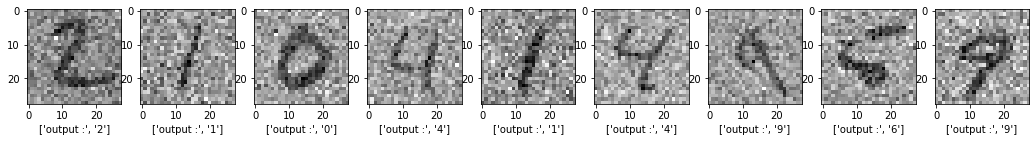

In [20]:
## Output of final model (Noise images to denoise images and classification)

j = 1
plt.figure(figsize=(20, 2))
for i in range(1,10):
    ax = plt.subplot(1, 10, i)
    plt.imshow(noisy_input_test[i].reshape(28, 28), cmap="binary") ### noisy input test data
    predicted_classes = model_final.predict(noisy_input_test)[j]
    j += 1
    bestclass = ''
    bestconf = -1
    for n in range(10):
        if (predicted_classes[n] > bestconf):
            bestclass = str(n)
            bestconf = predicted_classes[n]
            plt.xlabel(["output :", bestclass])
plt.show()

# Test Image is Noise image. 
# Intermediate output is denoise image (It is shown in the below cell)
# Output is the final classification.

# In the below diagram, only input noisy image and its final classification output is shown. 
# Intermediate denoisy image and output is show in next cell 

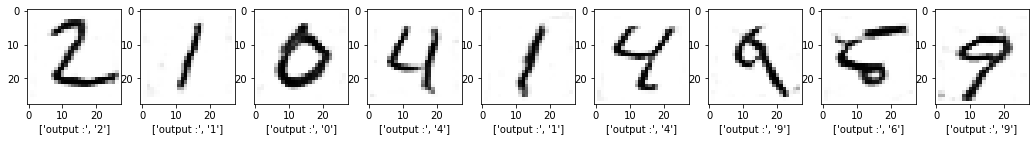

In [21]:
#Intermediate output taken from final model

j = 1
plt.figure(figsize=(20, 2))
for i in range(1,10):
    ax = plt.subplot(1, 10, i)
    denoised_images = intermediate_layer_model.predict(noisy_input_test)[j]
    predicted_classes = model_final.predict(noisy_input_test)[j]
    plt.imshow(denoised_images.reshape(28, 28), cmap="binary") ### denoise output from intermediate layer
    j += 1
    bestclass = ''
    bestconf = -1
    for n in range(10):
        if (predicted_classes[n] > bestconf):
            bestclass = str(n)
            bestconf = predicted_classes[n]
            plt.xlabel(["output :", bestclass])
plt.show()
